In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA
import plotly.express as px

In [2]:
# Path configuration
RAW_DATA_DIR = Path("../data/raw/EGATUR")
PROCESSED_DATA_DIR = Path("../data/processed")
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

# Data from Source

In this section, we load and process the raw EGATUR data files, and rename variables according to the official documentation provided by INE.

Spanish Statistical Office (INE):  
[Tourist Expenditure Survey (EGATUR)](https://www.ine.es)  

⚠️ *INE is not responsible for results derived from independent calculations using these files.*  

The data comes from the **Tourist Expenditure Survey (EGATUR)** published by the Spanish Statistical Office (INE).  
Each month, two files are provided:

- `elevado_eg_mod_web_tur_*.txt`: information at the **traveler** level (whole trip).
- `etapas_eg_mod_web_*.txt`: information at the **stage** level within a trip.


The period that have been used goes from july of 2022 to june of 2025.

---

In [3]:
# Auxiliary functions
def load_traveler_file(filepath: Path) -> pd.DataFrame:
    """Load one 'traveler' file from Egatur"""
    df = pd.read_csv(filepath, sep=";", decimal=".", dtype=str)
    
    for col in ["A13", "gastototal", "factoregatur"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    
    return df

def load_stage_file(filepath: Path) -> pd.DataFrame:
    """Load one 'stage' file from Egatur"""
    df = pd.read_csv(filepath, sep=";", decimal=".", dtype=str)
    df["stage_nights"] = pd.to_numeric(df["pernoc_etapa"], errors="coerce")
    return df

def process_folder(folder: Path) -> pd.DataFrame:
    """Load traveler file from one specific folder"""
    traveler_file = next(folder.glob("elevado_*.txt"))
    return load_traveler_file(traveler_file)

def build_dataset(base_dir: Path) -> pd.DataFrame:
    """Build the complete dataset from all folders"""
    all_dfs = []
    for folder in base_dir.iterdir():
        if folder.is_dir():
            df = process_folder(folder)
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)


"""
def process_folder(folder: Path) -> pd.DataFrame:
    \"""Join traveler + stages in one specific folder\"""
    traveler_file = next(folder.glob("elevado_*.txt"))
    stage_file = next(folder.glob("etapas_*.txt"))
    
    df_traveler = load_traveler_file(traveler_file)
    df_stage = load_stage_file(stage_file)
    
    # Aggregate info of stages by A0_1 (id)
    agg_stages = df_stage.groupby("A0_1").agg(
        stages_count=("C9_0", "nunique"),
        total_stage_nights=("stage_nights", "sum")
    ).reset_index()
    
    # Join with traveler dataset
    df = df_traveler.merge(agg_stages, on="A0_1", how="left")
    
    return df

def build_dataset(base_dir: Path) -> pd.DataFrame:
    \"""Build the complete dataset from all folders\"""
    all_dfs = []
    for folder in base_dir.iterdir():
        if folder.is_dir():
            df = process_folder(folder)
            all_dfs.append(df)
    return pd.concat(all_dfs, ignore_index=True)
"""

'\ndef process_folder(folder: Path) -> pd.DataFrame:\n    """Join traveler + stages in one specific folder"""\n    traveler_file = next(folder.glob("elevado_*.txt"))\n    stage_file = next(folder.glob("etapas_*.txt"))\n\n    df_traveler = load_traveler_file(traveler_file)\n    df_stage = load_stage_file(stage_file)\n\n    # Aggregate info of stages by A0_1 (id)\n    agg_stages = df_stage.groupby("A0_1").agg(\n        stages_count=("C9_0", "nunique"),\n        total_stage_nights=("stage_nights", "sum")\n    ).reset_index()\n\n    # Join with traveler dataset\n    df = df_traveler.merge(agg_stages, on="A0_1", how="left")\n\n    return df\n\ndef build_dataset(base_dir: Path) -> pd.DataFrame:\n    """Build the complete dataset from all folders"""\n    all_dfs = []\n    for folder in base_dir.iterdir():\n        if folder.is_dir():\n            df = process_folder(folder)\n            all_dfs.append(df)\n    return pd.concat(all_dfs, ignore_index=True)\n'

In [4]:
df = build_dataset(RAW_DATA_DIR)

In [5]:
df.describe(include='all')

,mm_aaaa,A0,A0_1,A0_7,A1,pais,ccaa,A13,aloja,motivo,A16,gastototal,factoregatur
count,235788,235788,235788,235788,235788,235788,235788,235788.000000,235788,235788,235788,235788.000000,2.357880e+05
unique,35,1,220962,2,4,14,19,NaN,3,3,2,NaN,NaN
top,072023,2,20230500028314,2,2,08,09,NaN,1,1,6,NaN,NaN
freq,8946,235788,8,220853,192891,42643,50697,NaN,142948,177019,193659,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.049091,NaN,NaN,NaN,1446.224164,1.092479e+03
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.740294,NaN,NaN,NaN,1226.615313,1.575220e+03
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,4.862770,7.406998e-09
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,763.822467,2.850308e+02
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,1160.881182,6.626692e+02
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,1680.131326,1.349838e+03


### 🔹 Variables in `elevado_eg_mod_web_tur_*.txt` (Trips)

| Variable           | Type     | Values / Example   | Description |

|--------------------|----------|-------------------|-------------|

| `month_year`       | string   | `0123`            | Reference month and year (MMYY). |

| `source`           | string   | `2`               | Survey source (2 = Egatur). |

| `trip_id`          | string   | `20200200009238`  | **Unique identifier** for the questionnaire (primary key for joins). |

| `tourist_type_id`  | string   | `2`, `8`          | Tourist type: <br>• 2 = Non-resident (non-transit) <br>• 8 = Non-resident in transit. |

| `exit_route_id`    | string   | `1-4`             | Exit route: <br>1 = Road, 2 = Airport, 3 = Port, 4 = Train. |

| `country`          | string   | `01-15`           | Country of residence: <br>01 = Germany, 02 = Belgium, …, 15 = Rest of the world. |

| `region`           | string   | `01-19`           | Main destination Autonomous Community (region): <br>01 = Andalusia, …, 19 = Melilla. |

| `total_nights`     | integer  | `3`               | Total overnight stays during the trip. |

| `accommodation`    | string   | `1-3`             | Main accommodation type: <br>1 = Hotels and similar, 2 = Other market, 3 = Non-market. |

| `purpose`          | string   | `1-3`             | Main trip purpose: <br>1 = Leisure/holidays, 2 = Business, 3 = Other. |

| `package_tour_id`  | string   | `1`, `6`          | Package tour: 1 = Yes, 6 = No. |

| `total_expenditure`| decimal  | `2341.84`         | Total expenditure for the trip/excursion. |

| `expansion_factor` | decimal  | `1998.09`         | Expansion factor (sampling weight). |



**Methodological notes:**

- **Estimated tourist expenditure** = `total_expenditure * expansion_factor`.

- **Number of tourists** = sum of `expansion_factor`.

- **Estimated overnight stays** = `total_nights * expansion_factor`.

- **Daily average expenditure** = total expenditure / estimated overnight stays.
- **Average trip length** = estimated overnight stays / number of tourists.


---

### 🔹 Variables in `etapas_eg_mod_web_*.txt` (Stages)

| Variable         | Type     | Values / Example   | Description |

|------------------|----------|-------------------|-------------|

| `month_year`     | string   | `0123`            | Reference month and year (MMYY). |

| `trip_id`        | string   | `20200200009238`  | Unique identifier for the questionnaire (**join key with trips**). |

| `stage_id`       | string   | `01`, `02`, …     | Stage identifier within the trip. |

| `stage_region`   | string   | `01-19`           | Destination Autonomous Community (region) of the stage (same catalog as `region`). |

| `stage_nights`   | integer  | `22`              | Number of overnight stays in the stage. |



**Notes:**

- A single `trip_id` may contain multiple stages (e.g., a trip across several regions).

- The join **trips ↔ stages** is done using `trip_id`.



---

**Suggestion:** Consider providing a data dictionary or codebook as an appendix for future reference.

### 🔹 Variables in `elevado_eg_mod_web_tur_*.txt` (trips)

| Variable       | Type     | Values / Example   | Description |
|----------------|----------|-------------------|-------------|
| `mm_aaaa`      | string   | `0123`            | Reference month and year (MMYY). |
| `A0`           | string   | `2`               | Survey source (2 = Egatur). |
| `A0_1`         | string   | `20200200009238`  | **Unique identifier** of the questionnaire (primary key for joins). |
| `A0_7`         | string   | `2`, `8`          | Tourist type: <br>• 2 = Non-resident (non-transit) <br>• 8 = Non-resident in transit. |
| `A1`           | string   | `1-4`             | Exit route: <br>1 = Road, 2 = Airport, 3 = Port, 4 = Train. |
| `pais`         | string   | `01-15`           | Country of residence: <br>01 = Germany, 02 = Belgium, …, 15 = Rest of the world. |
| `ccaa`         | string   | `01-19`           | Main destination Autonomous Community (region): <br>01 = Andalusia, …, 19 = Melilla. |
| `A13`          | integer  | `3`               | Total overnight stays in the trip. |
| `aloja`        | string   | `1-3`             | Main accommodation type: <br>1 = Hotels and similar, 2 = Other market, 3 = Non-market. |
| `motivo`       | string   | `1-3`             | Main trip purpose: <br>1 = Leisure/holidays, 2 = Business, 3 = Other. |
| `A16`          | string   | `1`, `6`          | Package tour: 1 = Yes, 6 = No. |
| `gastototal`   | decimal  | `2341.84`         | Total expenditure of the trip/excursion. |
| `factoregatur` | decimal  | `1998.09`         | Expansion factor (sampling weight). |

**Methodological notes:**
- **Estimated tourist expenditure** = `gastototal * factoregatur`.
- **Number of tourists** = sum of `factoregatur`.
- **Estimated overnight stays** = `A13 * factoregatur`.
- **Daily average expenditure** = total expenditure / estimated overnight stays.
- **Average trip length** = estimated overnight stays / tourists.

---

### 🔹 Variables in `etapas_eg_mod_web_*.txt` (stages)

At the end, this information has been decided not to be used.

| Variable       | Type     | Values / Example   | Description |
|----------------|----------|-------------------|-------------|
| `mm_aaaa`      | string   | `0123`            | Reference month and year (MMYY). |
| `A0_1`         | string   | `20200200009238`  | Unique identifier of the questionnaire (**join key with trips**). |
| `C9_0`         | string   | `01`, `02`, …     | Stage identifier within the trip. |
| `ccaa_etapa`   | string   | `01-19`           | Destination Autonomous Community (region) of the stage (same catalog as `ccaa`). |
| `pernoc_etapa` | integer  | `22`              | Number of overnight stays in the stage. |

**Notes:**
- A single `A0_1` may contain multiple stages (e.g., a trip across several regions).
- The join **trips ↔ stages** is done using `A0_1`.

---

In [6]:
df.head()

,mm_aaaa,A0,A0_1,A0_7,A1,pais,ccaa,A13,aloja,motivo,A16,gastototal,factoregatur
0,122023,2,20221000016530,2,2,12,10,14,3,1,6,1810.465932,375.936311
1,122023,2,20221000020837,2,2,12,10,16,3,1,6,2035.596336,324.888905
2,122023,2,20221000022213,2,2,12,13,9,1,1,6,2460.725851,115.019771
3,122023,2,20221000039018,2,2,12,10,27,3,1,6,3010.324516,86.451770
4,122023,2,20221000039098,2,2,12,05,14,3,3,6,1747.853281,236.780128


## Feature Engineering

Feature engineering includes decoding categorical variables, creating new features, and preparing the dataset for analysis.

In [7]:
# Decode categorical variables
# Decode 'A0_7' (Tourist type)
df["tourist_type"] = df["A0_7"].map({"2": "Non-resident", "8": "Non-resident in transit"})

# Decode 'A1' (Exit route)
df["exit_route"] = df["A1"].map({"1": "Road", "2": "Airport", "3": "Port", "4": "Train"})

# Decode 'pais' (Country of residence)
country_map = {
    "01": "Germany", "02": "Belgium", "03": "France", "04": "Italy", "05": "Netherlands",
    "06": "Portugal", "07": "United Kingdom", "08": "Switzerland", "09": "Nordic countries",
    "10": "Rest of Europe", "11": "United States", "12": "Rest of America", "13": "Rest of the world",
    "14": "Russia", "15": "Rest of the world"
}
df["country"] = df["pais"].map(country_map).fillna(df["pais"])

# Decode 'ccaa' (Main destination Autonomous Community)
region_map = {
    "01": "Andalusia", "02": "Aragon", "03": "Asturias", "04": "Balearic Islands", "05": "Canary Islands",
    "06": "Cantabria", "07": "Castile and Leon", "08": "Castile-La Mancha", "09": "Catalonia",
    "10": "Valencian Community", "11": "Extremadura", "12": "Galicia", "13": "Madrid",
    "14": "Murcia", "15": "Navarre", "16": "Basque Country", "17": "La Rioja", "18": "Ceuta", "19": "Melilla"
}
df["region"] = df["ccaa"].map(region_map).fillna(df["ccaa"])

# Decode 'aloja' (Main accommodation type)
df["accommodation"] = df["aloja"].map({"1": "Hotels and similar", "2": "Other market", "3": "Non-market"})

# Decode 'motivo' (Main trip purpose)
df["purpose"] = df["motivo"].map({"1": "Leisure/holidays", "2": "Business", "3": "Other"})

# Decode 'A16' (Package tour)
df["package_tour"] = df["A16"].map({"1": "Yes", "6": "No"})

In [8]:
# Translate columns name
df["total_expenditure"] = df["gastototal"]
df["expansion_factor"] = df["factoregatur"]

# Duration of trip
df["trip_length"] = df["A13"]

In [9]:
# Date
df["date"] = pd.to_datetime(df["mm_aaaa"], format="%m%Y")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# Season
def month_to_season(m):
    if m in [12, 1, 2]:
        return "winter"
    elif m in [3, 4, 5]:
        return "spring"
    elif m in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

df["season"] = df["month"].apply(month_to_season)

# Derived metrics
df["weighted_expenditure"] = df["total_expenditure"] * df["expansion_factor"]
df["daily_average_expenditure"] = df["total_expenditure"] / df["trip_length"]


In [10]:
df.drop(columns=[
    "mm_aaaa", "A0", "A0_1", "A0_7", "A1", "pais", "ccaa",
    "A13", "aloja", "motivo", "month", "year", "A16",
    "gastototal", "factoregatur", "expansion_factor"
], inplace=True)

In [11]:
df.head()

,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,trip_length,date,season,weighted_expenditure,daily_average_expenditure
0,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,1810.465932,14,2023-12-01,winter,680619.883798,129.318995
1,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,2035.596336,16,2023-12-01,winter,661342.665150,127.224771
2,Non-resident,Airport,Rest of America,Madrid,Hotels and similar,Leisure/holidays,No,2460.725851,9,2023-12-01,winter,283032.122790,273.413983
3,Non-resident,Airport,Rest of America,Valencian Community,Non-market,Leisure/holidays,No,3010.324516,27,2023-12-01,winter,260247.882432,111.493501
4,Non-resident,Airport,Rest of America,Canary Islands,Non-market,Other,No,1747.853281,14,2023-12-01,winter,413856.923030,124.846663


In [12]:
df.describe(include='all')

,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,trip_length,date,season,weighted_expenditure,daily_average_expenditure
count,235788,235788,235788,235788,235788,235788,235788,235788.000000,235788.000000,235788,235788,2.357880e+05,235788.000000
unique,2,4,13,19,3,3,2,NaN,NaN,NaN,4,NaN,NaN
top,Non-resident,Airport,Switzerland,Catalonia,Hotels and similar,Leisure/holidays,No,NaN,NaN,NaN,summer,NaN,NaN
freq,220853,192891,42643,50697,142948,177019,193659,NaN,NaN,NaN,71498,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1446.224164,9.049091,2023-12-22 18:03:06.146877696,NaN,1.431399e+06,234.004400
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.862770,1.000000,2022-07-01 00:00:00,NaN,2.560074e-05,3.496201
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,763.822467,4.000000,2023-05-01 00:00:00,NaN,2.811581e+05,131.672923
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1160.881182,6.000000,2023-12-01 00:00:00,NaN,7.645250e+05,192.197580
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.131326,10.000000,2024-09-01 00:00:00,NaN,1.718127e+06,266.283290
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43259.859527,182.000000,2025-06-01 00:00:00,NaN,2.085136e+08,8495.266238


In [13]:
df.to_csv(PROCESSED_DATA_DIR / "egatur_full_dataset.csv", index=False)

# Exploratory Data Analysis (EDA)

This section explores the main characteristics of the dataset, including univariate, bivariate, and multivariate analyses.

## 1. Introduction

### Objective of the Analysis
The main objective of this analysis is to understand the behavior of international tourists visiting Spain, focusing on key metrics such as trip duration, total expenditure, daily spending, and patterns across regions and countries of origin.

### Dataset Description
- **Source:** Spanish Statistical Office (INE) – Tourist Expenditure Survey (EGATUR).
- **Period:** Monthly data from [specify range, e.g., January 2023 to December 2023].
- **Unit of observation:** One row per tourist trip (traveler).
- **Key Variables:**
  - `trip_length` – Duration of the trip in nights.
  - `total_expenditure` – Total expenditure per trip.
  - `daily_average_expenditure` – Average expenditure per night.
  - `country` – Tourist's country of residence.
  - `region` – Main destination region in Spain.
  - `accommodation` – Type of accommodation.
  - `purpose` – Main purpose of the trip.
  - `season` – Season of travel (derived from month).

### Goals of the EDA
- Identify **spending patterns** across countries, regions, and types of tourists.
- Explore **seasonality** (briefly, it is not the objective of this EDA).
- Understand **tourist profiles** in terms of accommodation, purpose, and trip length.
- Prepare the dataset for further **modeling or reporting**.

## Auxiliary functions

In [14]:
# DESCRIPTIVE & DISTRIBUTIONS
def plot_missing_values(df: pd.DataFrame, plot_type: str = "bar"):
    """
    Visualize missing values of a DataFrame using missingno.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to analyze
    plot_type : str
        Type of plot: "bar", "matrix", "heatmap", "dendrogram"
    """
    if plot_type == "bar":
        msno.bar(df)
    elif plot_type == "matrix":
        msno.matrix(df)
    elif plot_type == "heatmap":
        msno.heatmap(df)
    elif plot_type == "dendrogram":
        msno.dendrogram(df)
    else:
        raise ValueError("plot_type must be 'bar', 'matrix', 'heatmap' or 'dendrogram'")
    
    plt.show()


def plot_numerical_distributions(df: pd.DataFrame, numerical_cols: list, bins=30):
    """Plot histograms and KDEs for numerical features"""
    for col in numerical_cols:
        plt.figure(figsize=(8,4))
        sns.histplot(df[col], kde=True, bins=bins)
        plt.title(f"Distribution of {col}")
        plt.show()

def plot_boxplots_numerical_limit(df: pd.DataFrame, numerical_cols: list, percentiles=None):
    """Plot boxplots for numerical features with limit to p99"""
    for col in numerical_cols:
        print(col, df[col].describe(percentiles=percentiles))
    
        plt.figure(figsize=(8,4))
        sns.boxplot(x=df[col])
        plt.xlim(0, df[col].quantile(0.99))  # limit to p99
        plt.title(f"{col} (zoom to p99)")
        plt.show()

def plot_categorical_counts(df: pd.DataFrame, categorical_cols: list):
    """Plot bar charts for categorical features"""
    for col in categorical_cols:
        plt.figure(figsize=(8,4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.xticks(rotation=45)
        plt.title(f"Countplot of {col}")
        plt.show()


# BIVARIATE ANALYSIS
def plot_boxplots(df: pd.DataFrame, categorical_cols: list, target: str):
    """Boxplots of target numerical vs categorical features"""
    for col in categorical_cols:
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=col, y=target)
        plt.xticks(rotation=45)
        plt.title(f"{target} vs {col}")
        plt.show()


def plot_scatter_matrix(df: pd.DataFrame, numerical_cols: list):
    """Scatter matrix for numerical relationships"""
    sns.pairplot(df[numerical_cols], diag_kind="kde")
    plt.show()


def plot_correlation_heatmap(df: pd.DataFrame, numerical_cols: list):
    """Correlation matrix heatmap"""
    corr = df[numerical_cols].corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()


# TEMPORAL ANALYSIS
def plot_time_series(df: pd.DataFrame, date_col: str, target: str, freq="M"):
    """Time series trend of a numerical variable"""
    ts = df.groupby(date_col)[target].sum().resample(freq).sum()
    ts.plot(figsize=(12,5))
    plt.title(f"{target} over time")
    plt.ylabel(target)
    plt.xlabel("Date")
    plt.show()


def plot_seasonality(df: pd.DataFrame, season_col: str, target: str):
    """Average target by season"""
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x=season_col, y=target, estimator="mean")
    plt.title(f"Average {target} by {season_col}")
    plt.show()

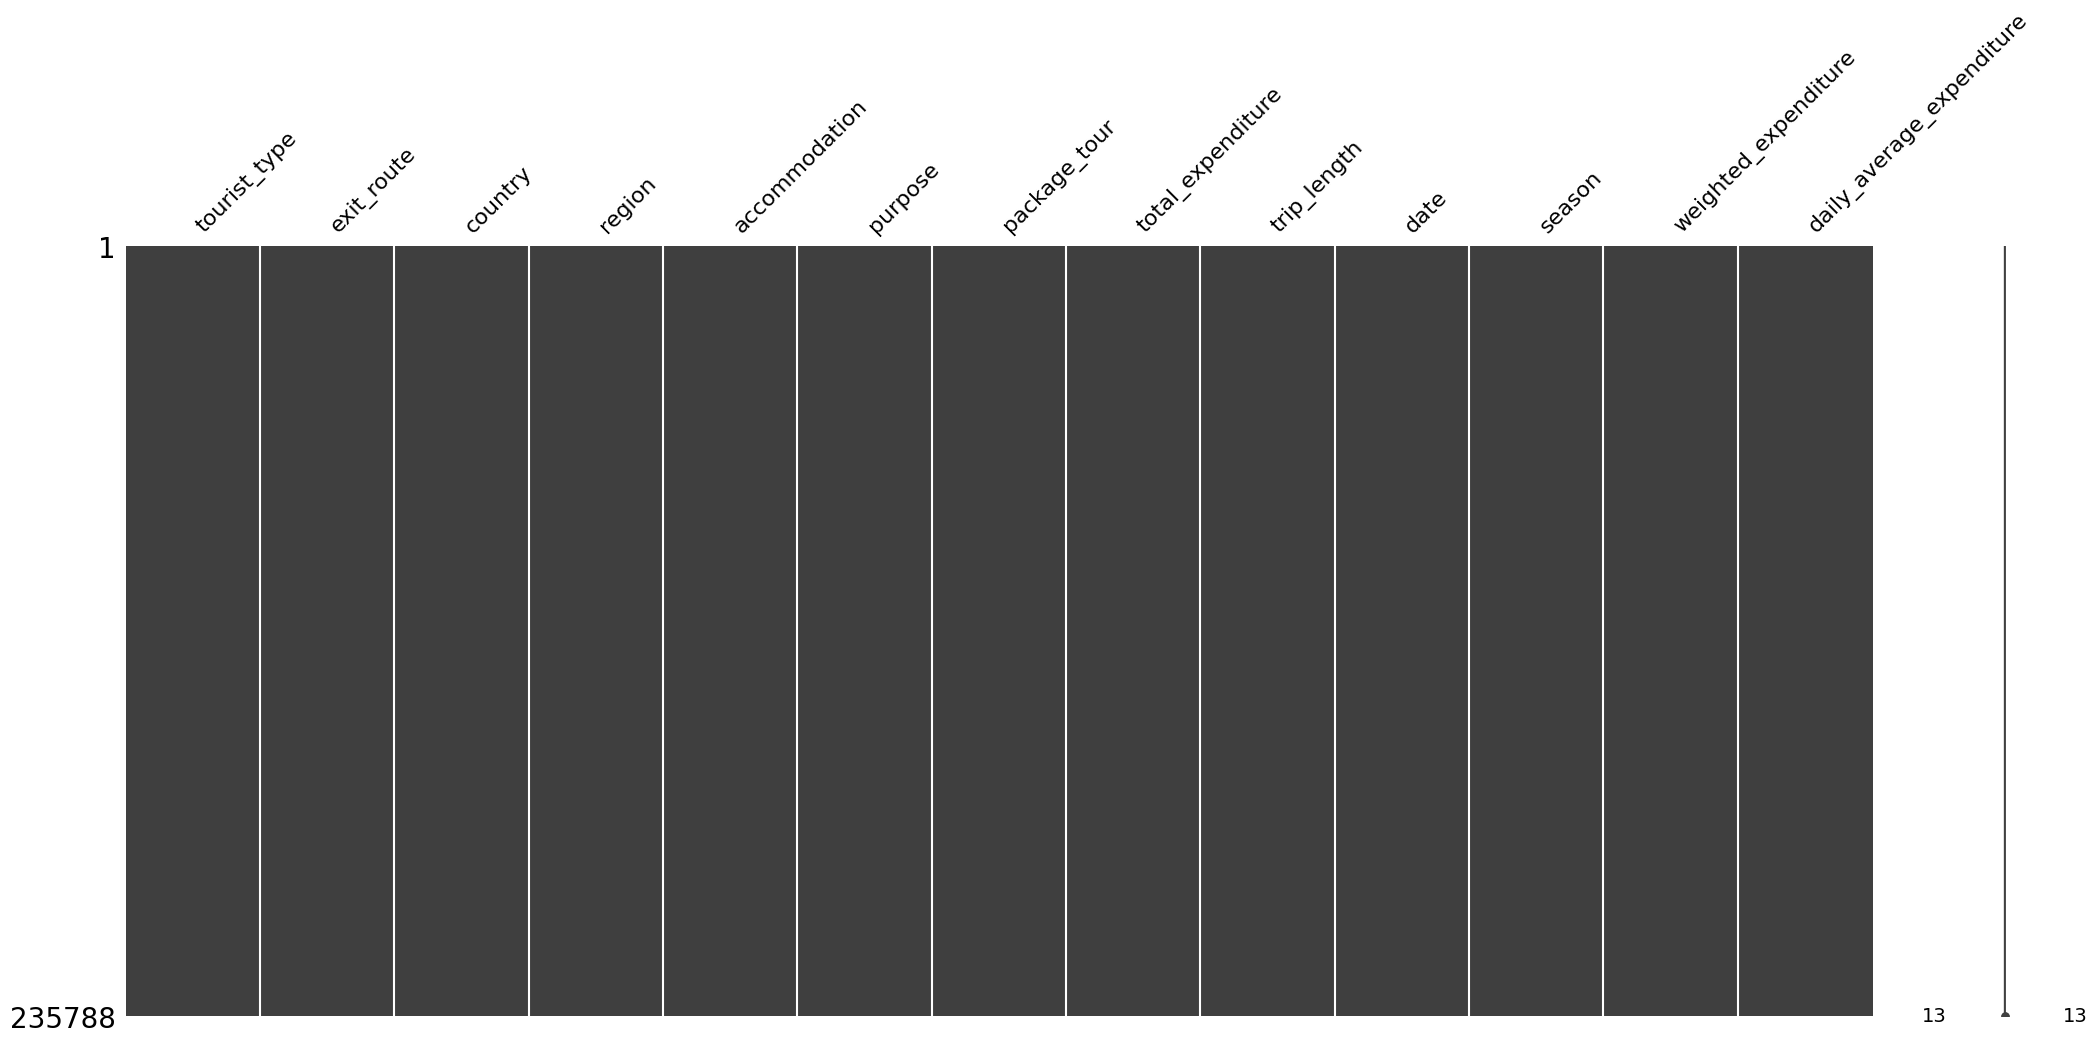

In [15]:
plot_missing_values(df, "matrix")     # Matrix of missing values

There are no missing values in the dataset, so no imputation or further comment is necessary.

## Univariate analysis

### First Look at Numerical Variables

We begin by examining the main numerical variables to understand their distributions and identify potential anomalies or outliers. Adjustments may be needed based on these initial findings.

In [16]:
df.describe(include='all')

,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,total_expenditure,trip_length,date,season,weighted_expenditure,daily_average_expenditure
count,235788,235788,235788,235788,235788,235788,235788,235788.000000,235788.000000,235788,235788,2.357880e+05,235788.000000
unique,2,4,13,19,3,3,2,NaN,NaN,NaN,4,NaN,NaN
top,Non-resident,Airport,Switzerland,Catalonia,Hotels and similar,Leisure/holidays,No,NaN,NaN,NaN,summer,NaN,NaN
freq,220853,192891,42643,50697,142948,177019,193659,NaN,NaN,NaN,71498,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1446.224164,9.049091,2023-12-22 18:03:06.146877696,NaN,1.431399e+06,234.004400
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.862770,1.000000,2022-07-01 00:00:00,NaN,2.560074e-05,3.496201
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,763.822467,4.000000,2023-05-01 00:00:00,NaN,2.811581e+05,131.672923
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1160.881182,6.000000,2023-12-01 00:00:00,NaN,7.645250e+05,192.197580
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1680.131326,10.000000,2024-09-01 00:00:00,NaN,1.718127e+06,266.283290
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43259.859527,182.000000,2025-06-01 00:00:00,NaN,2.085136e+08,8495.266238


In [17]:
numerical_cols = ["total_expenditure", "weighted_expenditure", "daily_average_expenditure", "trip_length"]
categorical_cols = ["country", "region", "accommodation", "purpose", "tourist_type", "exit_route", "package_tour", "season"]

date_col = df["date"]

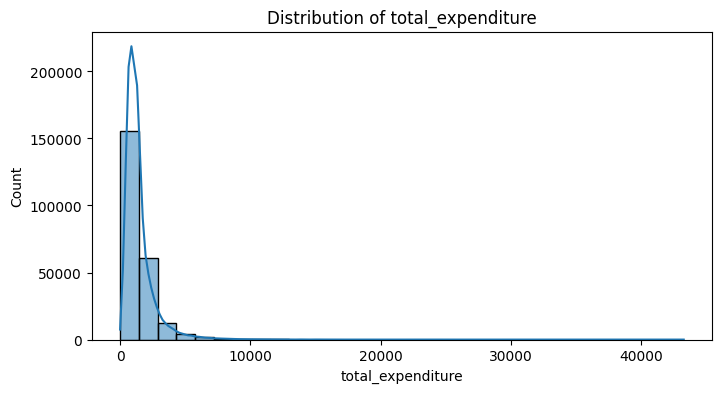

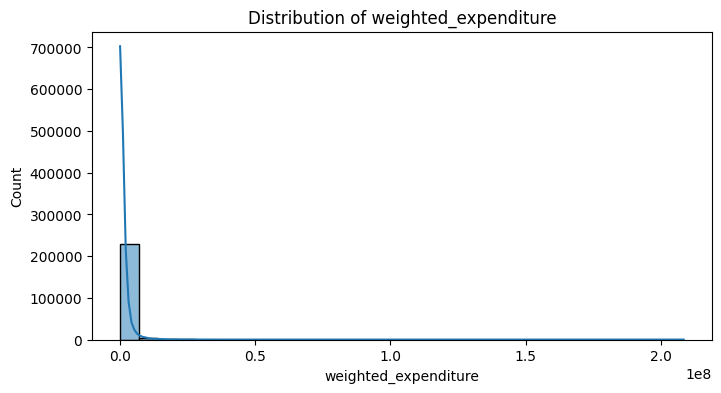

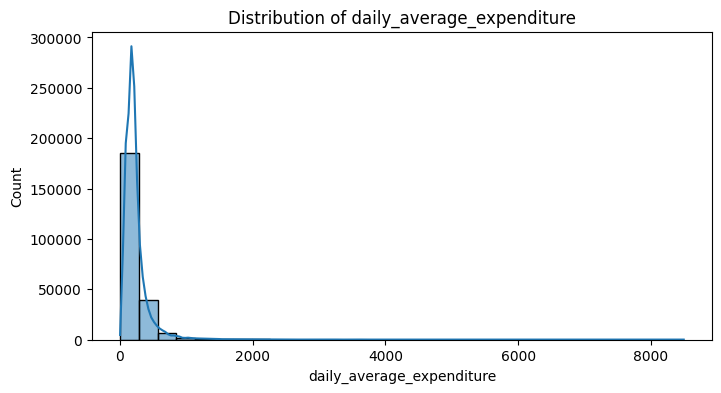

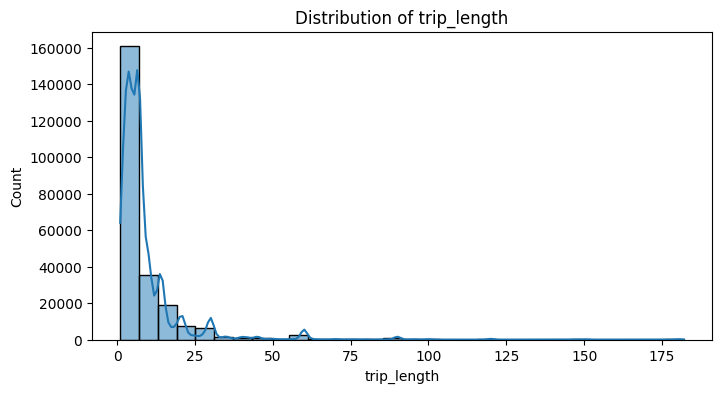

In [18]:
plot_numerical_distributions(df, numerical_cols)

## Outliers

Clearly there are outliers.

Let's examine the 0.95 and 0.99 percentiles and inspect boxplots limited to the 99th percentile.

total_expenditure count    235788.000000
mean       1446.224164
std        1226.615313
min           4.862770
50%        1160.881182
95%        3531.424406
99%        6264.509361
max       43259.859527
Name: total_expenditure, dtype: float64


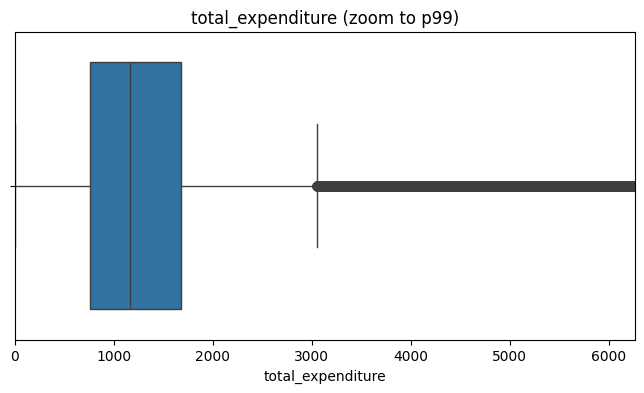

weighted_expenditure count    2.357880e+05
mean     1.431399e+06
std      2.479718e+06
min      2.560074e-05
50%      7.645250e+05
95%      4.694690e+06
99%      1.068429e+07
max      2.085136e+08
Name: weighted_expenditure, dtype: float64


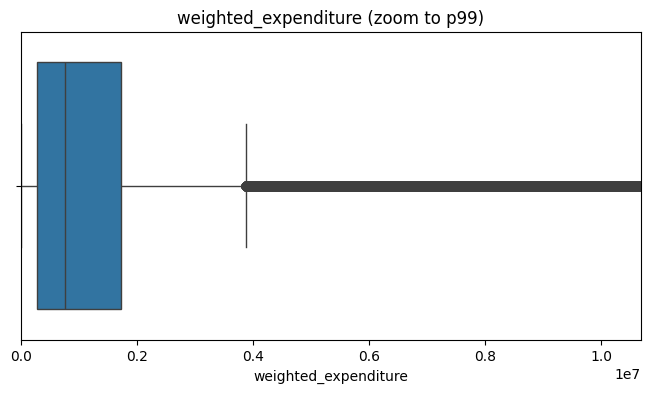

daily_average_expenditure count    235788.000000
mean        234.004400
std         202.229210
min           3.496201
50%         192.197580
95%         545.860871
99%        1037.075564
max        8495.266238
Name: daily_average_expenditure, dtype: float64


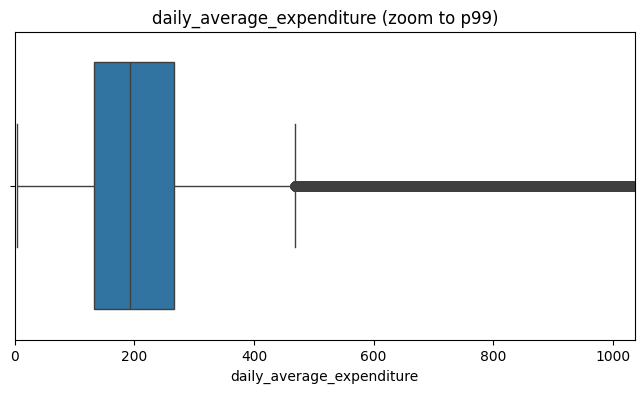

trip_length count    235788.000000
mean          9.049091
std          11.740294
min           1.000000
50%           6.000000
95%          30.000000
99%          60.000000
max         182.000000
Name: trip_length, dtype: float64


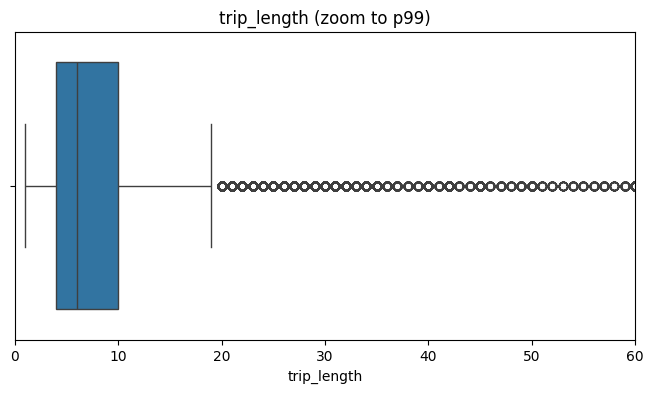

In [19]:
plot_boxplots_numerical_limit(df, numerical_cols, percentiles=[0.95, 0.99])

It is clear that there are outliers: for all numerical variables, there is a large difference between the 95th and 99th percentiles, and an even larger gap between the 99th percentile and the maximum value. This occurs because a significant proportion of travelers have very long trips (5% stay more than one month, with some trips lasting up to half a year).

### Initial Visualization of Numerical Variables

We first examine the main numerical variables to understand their distributions and identify potential anomalies or outliers.

In [20]:
for col in numerical_cols:
    threshold = df[col].quantile(0.99)
    outliers = df[df[col] > threshold]
    print(f"\nOutliers in {col} (>{threshold:.2f}): {len(outliers)} cases")
    display(outliers[categorical_cols + [col] + [x for x in numerical_cols if x != col]].head())


Outliers in total_expenditure (>6264.51): 2358 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,total_expenditure,weighted_expenditure,daily_average_expenditure,trip_length
83,Rest of the world,Madrid,Hotels and similar,Leisure/holidays,Non-resident in transit,Airport,No,winter,9189.420486,1.216096e+06,382.892520,24
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,6847.430400,1.808240e+05,97.820434,70
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,8657.309840,6.862533e+06,61.837927,140
299,Italy,Madrid,Non-market,Other,Non-resident,Port,No,winter,6573.069065,1.598287e+05,109.551151,60
300,Italy,Valencian Community,Non-market,Leisure/holidays,Non-resident,Port,No,winter,11881.099293,7.223760e+05,198.018322,60



Outliers in weighted_expenditure (>10684294.56): 2358 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,weighted_expenditure,total_expenditure,daily_average_expenditure,trip_length
520,Russia,Madrid,Hotels and similar,Leisure/holidays,Non-resident,Airport,Yes,winter,1.708630e+07,2595.903628,432.650605,6
635,Switzerland,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,No,winter,1.333860e+07,2393.664558,170.976040,14
675,Netherlands,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,Yes,winter,2.266275e+07,1503.152033,214.736005,7
896,Rest of the world,Catalonia,Other market,Leisure/holidays,Non-resident,Airport,No,winter,2.612933e+07,3133.884003,522.314001,6
1056,Switzerland,Canary Islands,Other market,Leisure/holidays,Non-resident,Airport,No,winter,2.676192e+07,1600.844063,228.692009,7



Outliers in daily_average_expenditure (>1037.08): 2358 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,daily_average_expenditure,total_expenditure,weighted_expenditure,trip_length
56,Rest of the world,Catalonia,Hotels and similar,Leisure/holidays,Non-resident,Airport,No,winter,1241.342136,2482.684272,4.765948e+06,2
936,Russia,Madrid,Hotels and similar,Business,Non-resident,Airport,No,winter,1429.031489,1429.031489,1.134596e+06,1
1010,Rest of the world,Catalonia,Hotels and similar,Leisure/holidays,Non-resident,Airport,No,winter,3358.043008,3358.043008,4.374556e+06,1
1067,Russia,Madrid,Hotels and similar,Other,Non-resident,Airport,No,winter,1375.110887,1375.110887,3.318525e+06,1
1079,Rest of the world,Madrid,Non-market,Other,Non-resident,Airport,No,winter,1123.788903,2247.577805,7.310548e+05,2



Outliers in trip_length (>60.00): 1826 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,trip_length,total_expenditure,weighted_expenditure,daily_average_expenditure
245,Switzerland,Andalusia,Other market,Leisure/holidays,Non-resident,Road,No,winter,61,4008.224867,2.506483e+06,65.708604
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,70,6847.430400,1.808240e+05,97.820434
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,140,8657.309840,6.862533e+06,61.837927
405,Switzerland,Navarre,Other market,Leisure/holidays,Non-resident,Road,No,winter,61,6132.959163,3.964900e+05,100.540314
593,Portugal,Valencian Community,Non-market,Leisure/holidays,Non-resident,Road,No,winter,95,2650.761734,8.541301e+05,27.902755


This result is unexpected: there are the same number of outliers in `total_expenditure`, `weighted_expenditure`, and `daily_average_expenditure`. However, the specific outliers are mostly different. Intuitively, one might expect that high total expenditure would be correlated with high daily expenditure, but this is not always the case in the data.

In [21]:
"""
from scipy.stats.mstats import winsorize

# Winsorization p0–p99
def winsorize_series(s: pd.Series, limits=(0.0, 0.01)):
    \"""
    Winsorize a pandas Series using scipy.stats.mstats.winsorize.
    By default clips the upper 1%.
    \"""
    return pd.Series(winsorize(s, limits=limits), index=s.index)

# Create winsorized copy
df_winsor = df.copy()
for col in numerical_cols:
    df_winsor[f"{col}_win"] = winsorize_series(df[col], limits=(0.0, 0.01))
"""

# Subset of “extreme tourists”
outliers_dict = {}
for col in numerical_cols:
    upper = df[col].quantile(0.99)
    
    # Save subset of outliers for this col
    outliers_col = df[(df[col] > upper)]
    outliers_dict[col] = outliers_col


# Global subset of outliers
# Union of all outliers in any variable
outliers_global = pd.concat(outliers_dict.values()).drop_duplicates()
print(f"\nTotal extreme tourists (any variable): {len(outliers_global)} cases")

# Show first cases
display(outliers_global[categorical_cols + numerical_cols].head())



Total extreme tourists (any variable): 7553 cases


,country,region,accommodation,purpose,tourist_type,exit_route,package_tour,season,total_expenditure,weighted_expenditure,daily_average_expenditure,trip_length
83,Rest of the world,Madrid,Hotels and similar,Leisure/holidays,Non-resident in transit,Airport,No,winter,9189.420486,1.216096e+06,382.892520,24
263,Germany,Balearic Islands,Non-market,Business,Non-resident,Airport,No,winter,6847.430400,1.808240e+05,97.820434,70
274,Netherlands,Murcia,Other market,Other,Non-resident,Airport,No,winter,8657.309840,6.862533e+06,61.837927,140
299,Italy,Madrid,Non-market,Other,Non-resident,Port,No,winter,6573.069065,1.598287e+05,109.551151,60
300,Italy,Valencian Community,Non-market,Leisure/holidays,Non-resident,Port,No,winter,11881.099293,7.223760e+05,198.018322,60


Although the number of outliers above the 99th percentile is similar across `total_expenditure`, `weighted_expenditure`, and `daily_average_expenditure`, the specific trips identified as outliers differ substantially. This is because each metric captures a different dimension:
- `total_expenditure` highlights trips with high absolute spending, regardless of duration.
- `weighted_expenditure` incorporates the survey expansion factor, so a moderately expensive trip can become an outlier if it represents many tourists.
- `daily_average_expenditure` identifies trips with high spending intensity per night, often short trips with concentrated expenditure.  

As a result, high total expenditure does not necessarily imply high daily expenditure, nor does a high weighted expenditure align perfectly with either of the other two.

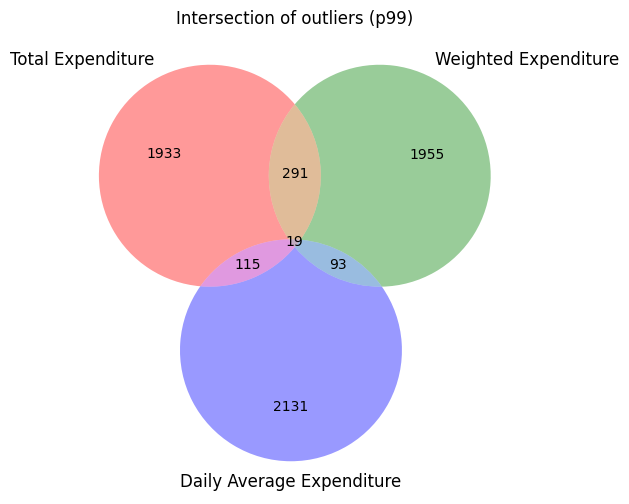

In [22]:
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

# Sets of outlier indices
out_total_expenditure = set(outliers_dict["total_expenditure"].index)
out_weighted_expenditure = set(outliers_dict["weighted_expenditure"].index)
out_daily_avg_expenditure = set(outliers_dict["daily_average_expenditure"].index)

plt.figure(figsize=(8,6))
venn3([out_total_expenditure, out_weighted_expenditure, out_daily_avg_expenditure],
      set_labels=('Total Expenditure', 'Weighted Expenditure', 'Daily Average Expenditure'))
plt.title("Intersection of outliers (p99)")
plt.show()

The Venn diagram confirms the lack of overlap between these sets of outliers: very few trips appear as outliers in more than one metric simultaneously. This illustrates that extreme values in one dimension (e.g., total spending) are not systematically extreme in another (e.g., daily average spending).  

It emphasizes that outlier detection should be **metric-specific**, as using only one measure may miss unusual observations in other dimensions of tourist behavior.

/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the or

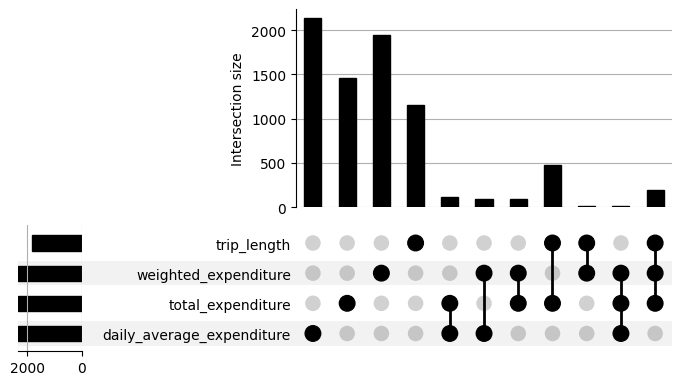

In [23]:
from upsetplot import UpSet, from_memberships

memberships = []
for i in df.index:
    flags = []
    for col in numerical_cols:
        if i in outliers_dict[col].index:
            flags.append(col)
    if flags:
        memberships.append(flags)

data = from_memberships(memberships)
UpSet(data, subset_size='count').plot()
plt.show()

As shown in the plot, there is a relationship between outliers in `trip_length` and `total_expenditure`. This is expected, as there is a clear dependency between total expenditure and both trip length and daily average expenditure.

/home/gregorio/Escritorio/Master/TFM/TFM/TFM_venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


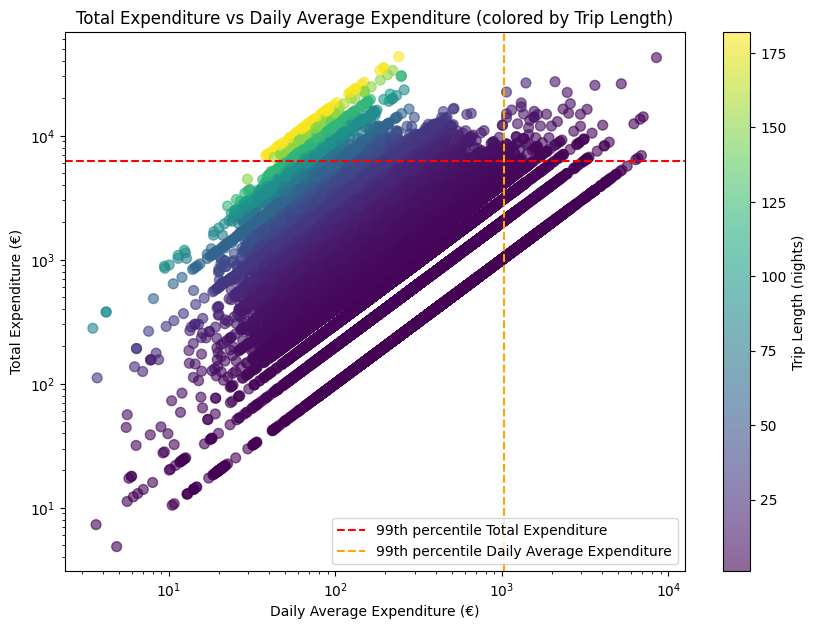

In [24]:
plt.figure(figsize=(10,7))

# Scatter plot log-log para mejor visibilidad
scatter = plt.scatter(
    x=df["daily_average_expenditure"],
    y=df["total_expenditure"],
    c=df["trip_length"],
    cmap="viridis",
    alpha=0.6,
    s=50
)

# Colorbar para trip_length
cbar = plt.colorbar(scatter)
cbar.set_label("Trip Length (nights)")

# Líneas de referencia para p99
plt.axhline(df["total_expenditure"].quantile(0.99), color="r", ls="--", label="99th percentile Total Expenditure")
plt.axvline(df["daily_average_expenditure"].quantile(0.99), color="orange", ls="--", label="99th percentile Daily Average Expenditure")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Daily Average Expenditure (€)")
plt.ylabel("Total Expenditure (€)")
plt.title("Total Expenditure vs Daily Average Expenditure (colored by Trip Length)")
plt.legend()
plt.show()

Before continuing, we will remove `total_expenditure` and `weighted_expenditure` from the analysis to simplify the dataset. We focus on `daily_average_expenditure` and `trip_length`, as these are more informative for identifying high spenders and understanding trip duration.

In [25]:
numerical_cols = ["daily_average_expenditure", "trip_length"]
df.drop(columns=["total_expenditure", "weighted_expenditure"], inplace=True)

It has been tested and confirmed that applying a logarithmic transformation to the two target variables results in distributions that are closer to normal. This can improve the interpretability and performance of subsequent analyses or models.

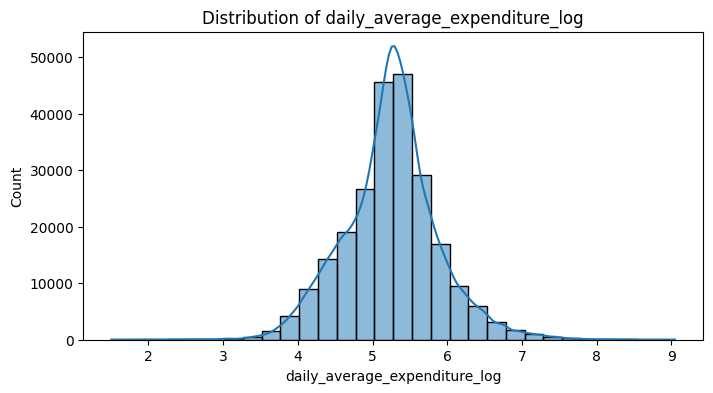

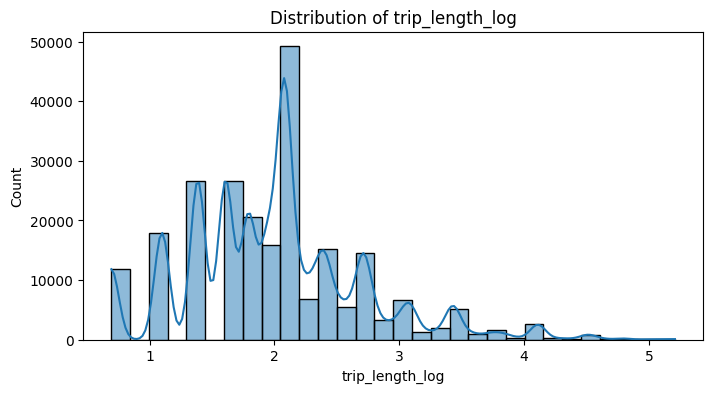

In [26]:
import numpy as np

# Create new log-transformed columns (adding +1 to avoid log(0))
for col in numerical_cols:
    df[f"{col}_log"] = np.log1p(df[col])  # log(1+x)

plot_numerical_distributions(df, [f"{col}_log" for col in numerical_cols])

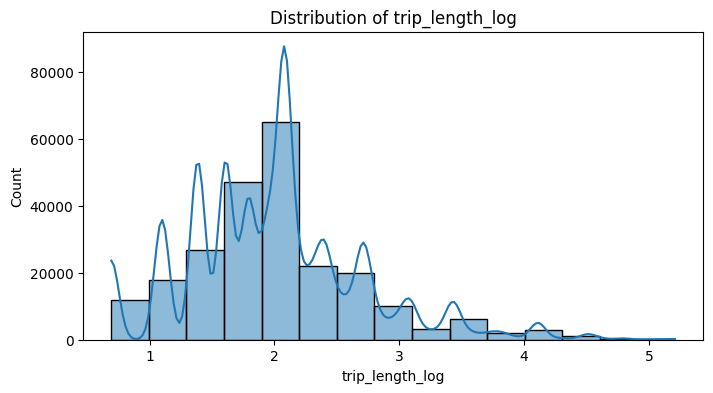

In [27]:
plot_numerical_distributions(df, [f"trip_length_log"], bins=15)

### Categorical variables

Let's now inspect the categorical variables.

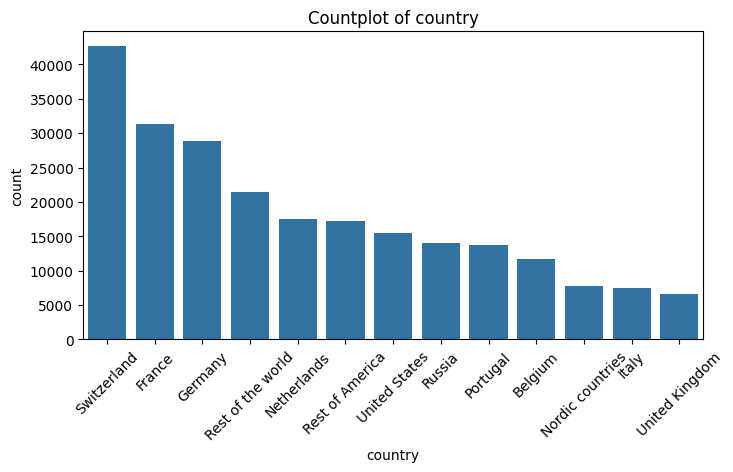

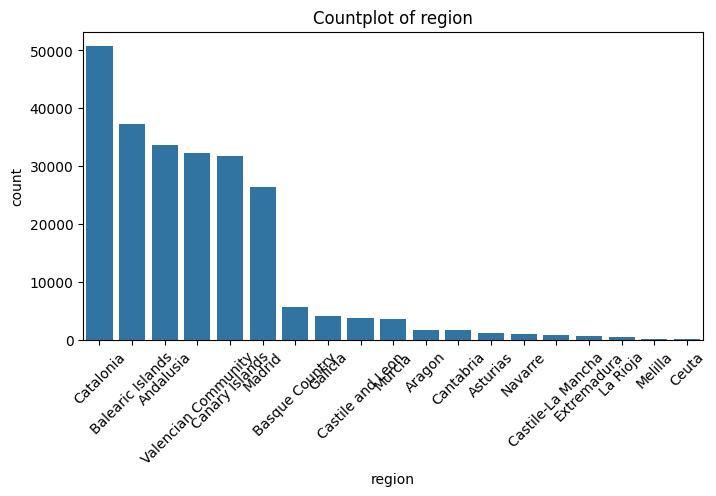

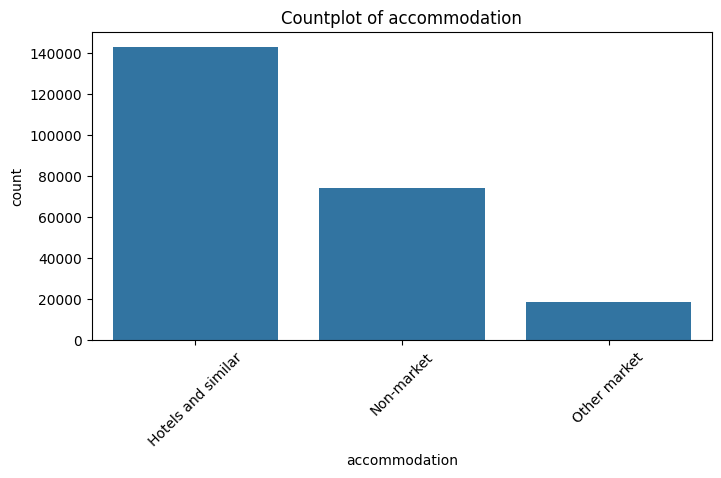

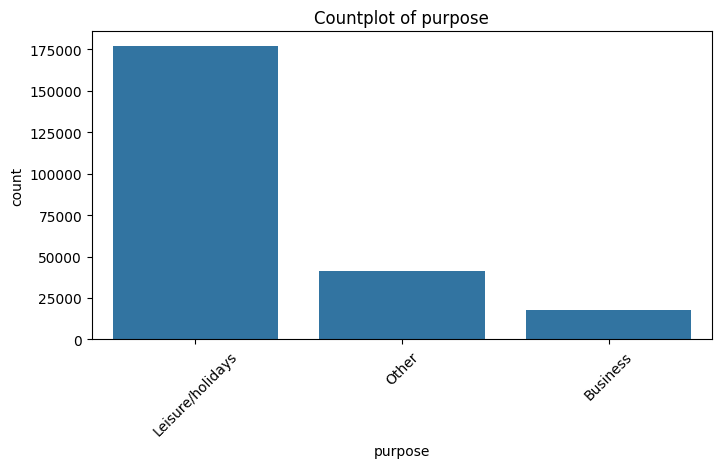

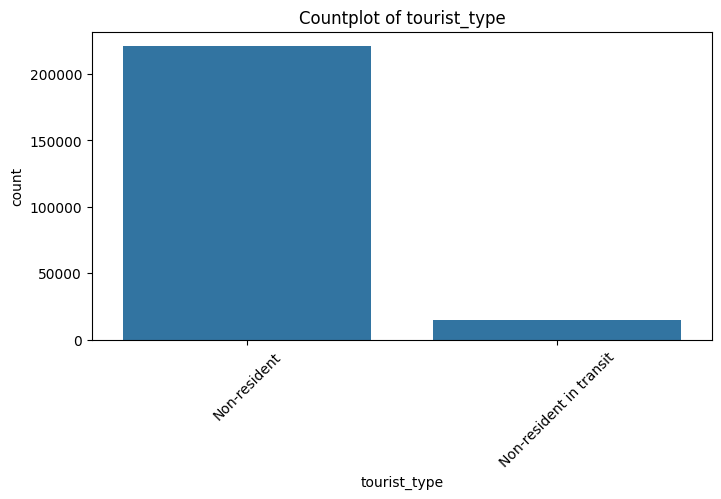

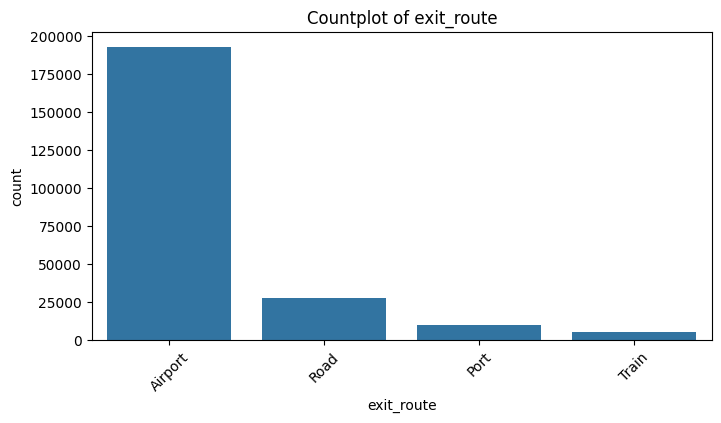

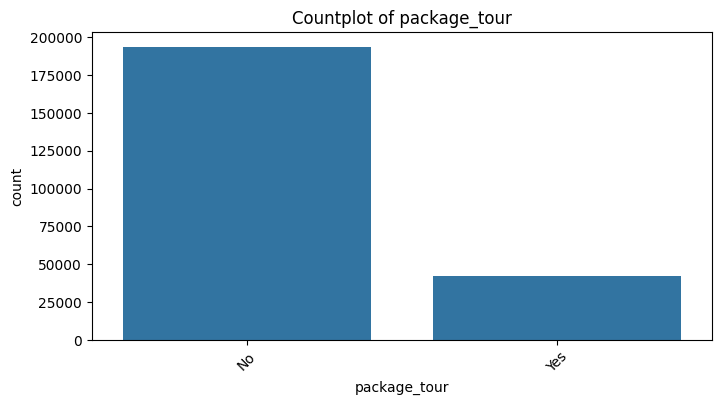

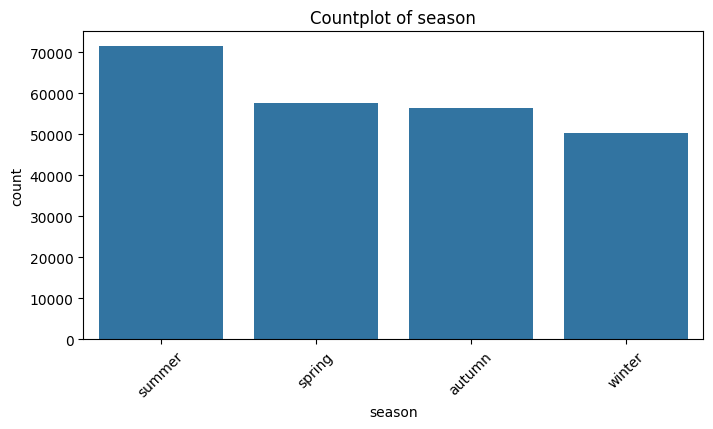

In [28]:
plot_categorical_counts(df, categorical_cols)

We observe that some categorical variables have many categories with low representation.

- **Region:** There are 19 regions in total, but the majority of trips are concentrated in six main destinations: Catalonia, Balearic Islands, Andalusia, Canary Islands, Valencian Community, and Madrid. We group all other regions under "Other" to reduce sparsity while preserving the main patterns.
- **Country:** Similarly, some countries have very few trips. For now, we keep all categories, but further consolidation may be considered during bivariate analysis if needed.
- **Other categorical variables:** Accommodation type, purpose, tourist type, exit route, package tour, and season are already dominated by a few categories, so no additional grouping is needed.

This preprocessing ensures that categorical variables are manageable and reduces noise caused by extremely rare categories, which is particularly important for modeling and visual exploration.

In [29]:
# Region -> 6 main + Other
top_regions = ["Catalonia", "Balearic Islands", "Andalusia", 
            "Canary Islands", "Valencian Community", "Madrid"]
df["region"] = df["region"].where(df["region"].isin(top_regions), "Other")

# Quick check
for col in categorical_cols:
    print(df[col].value_counts(normalize=True).round(3))
    print()

country
Switzerland          0.181
France               0.133
Germany              0.123
Rest of the world    0.091
Netherlands          0.074
Rest of America      0.073
United States        0.066
Russia               0.059
Portugal             0.058
Belgium              0.049
Nordic countries     0.033
Italy                0.032
United Kingdom       0.028
Name: proportion, dtype: float64

region
Catalonia              0.215
Balearic Islands       0.158
Andalusia              0.142
Valencian Community    0.137
Canary Islands         0.134
Madrid                 0.112
Other                  0.102
Name: proportion, dtype: float64

accommodation
Hotels and similar    0.606
Non-market            0.314
Other market          0.080
Name: proportion, dtype: float64

purpose
Leisure/holidays    0.751
Other               0.175
Business            0.074
Name: proportion, dtype: float64

tourist_type
Non-resident               0.937
Non-resident in transit    0.063
Name: proportion, dtype: float64

## Bivariate analysis

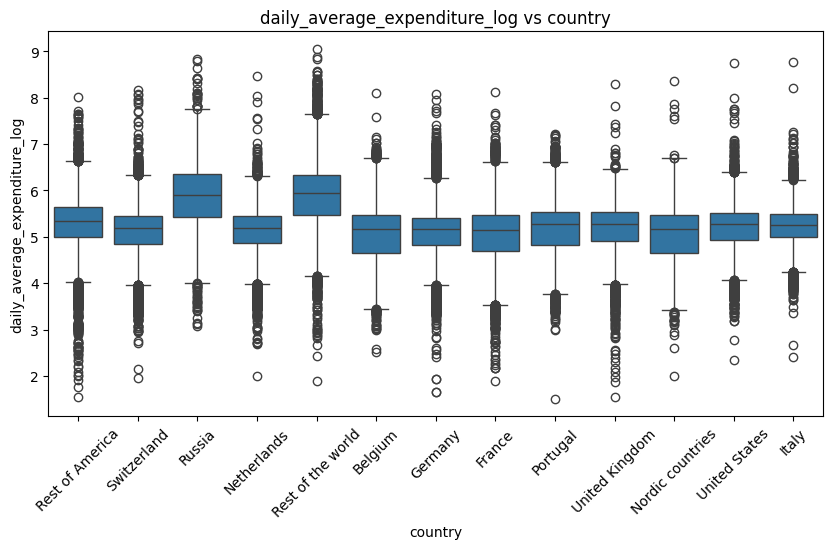

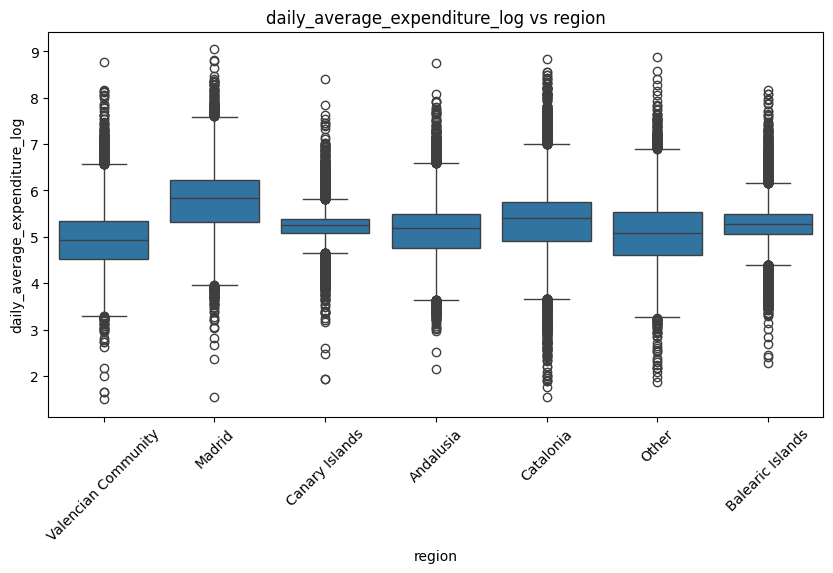

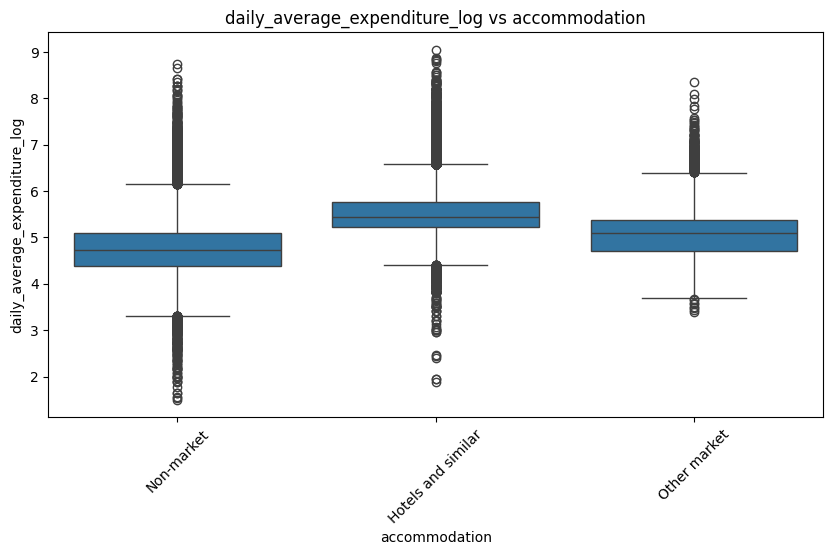

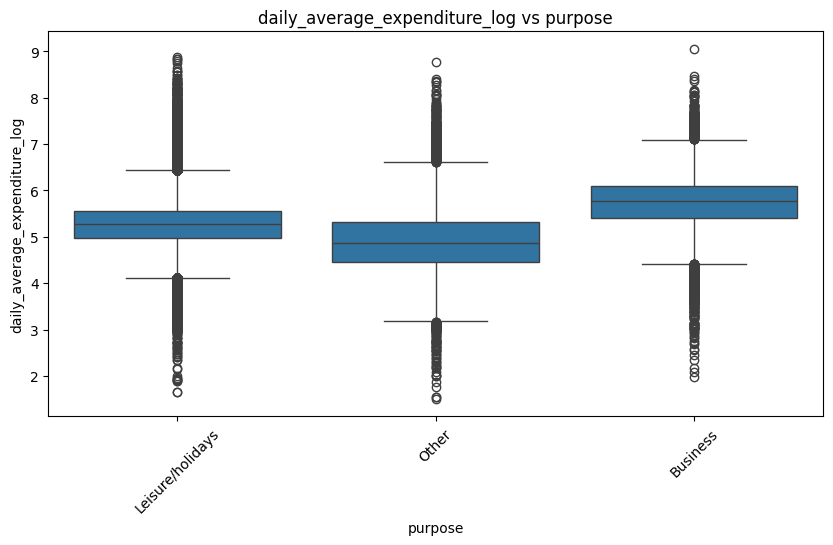

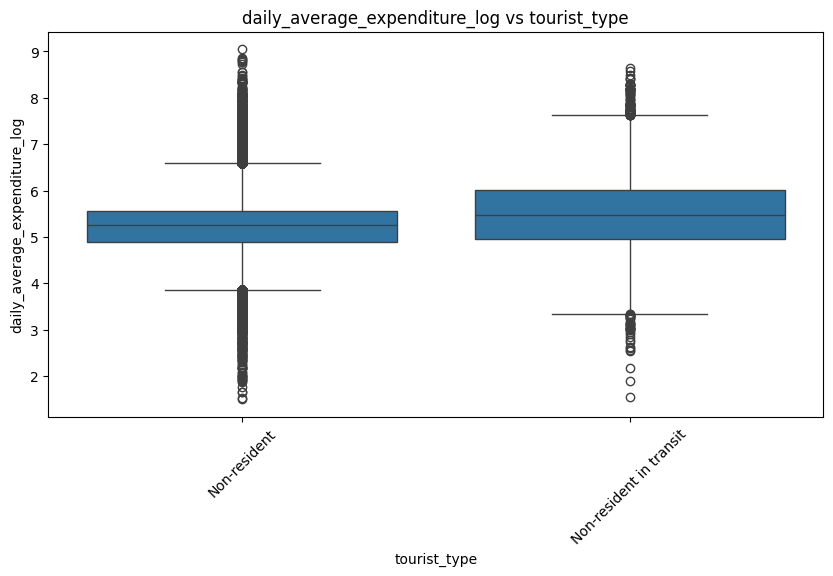

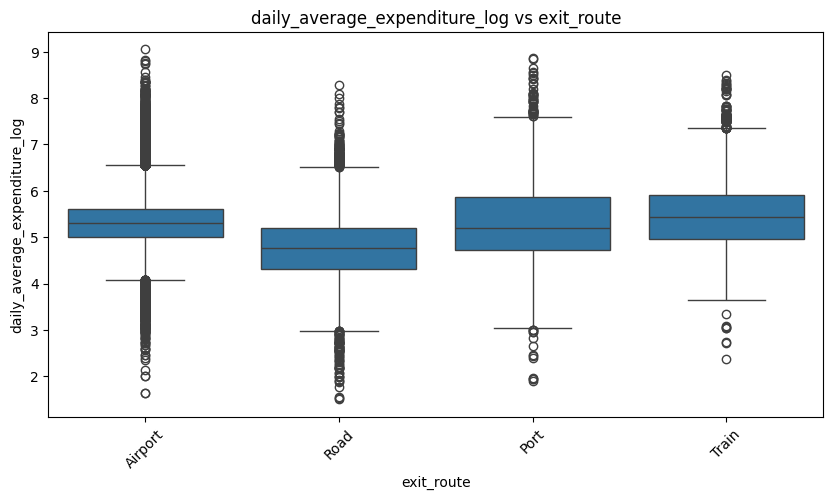

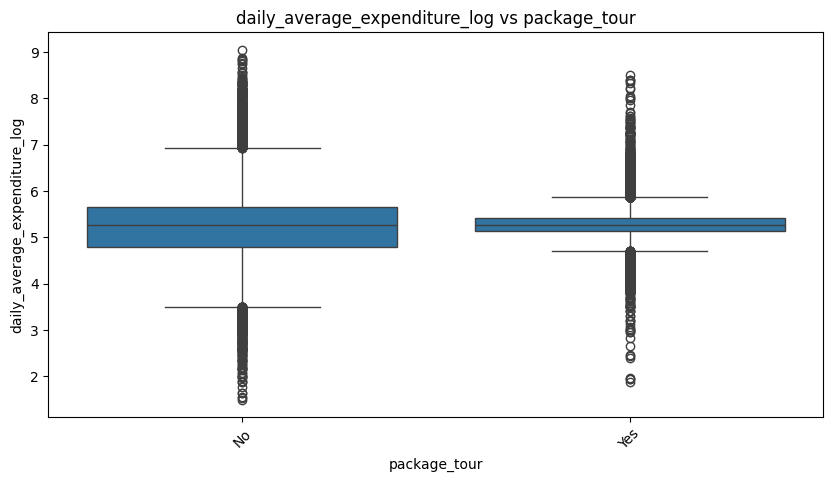

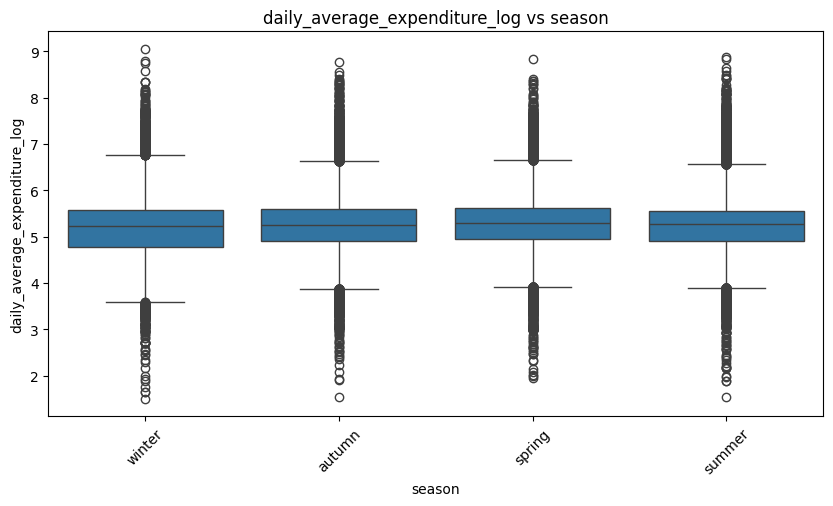

In [30]:
plot_boxplots(df, categorical_cols, target="daily_average_expenditure_log")

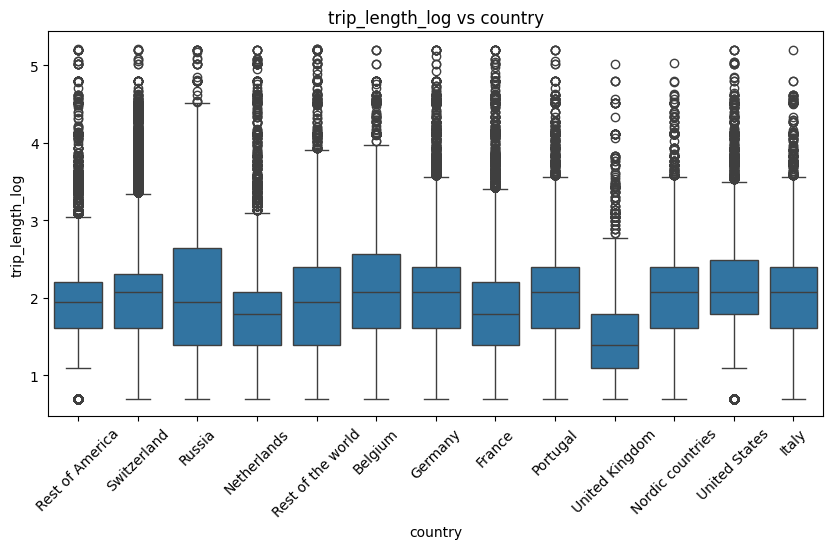

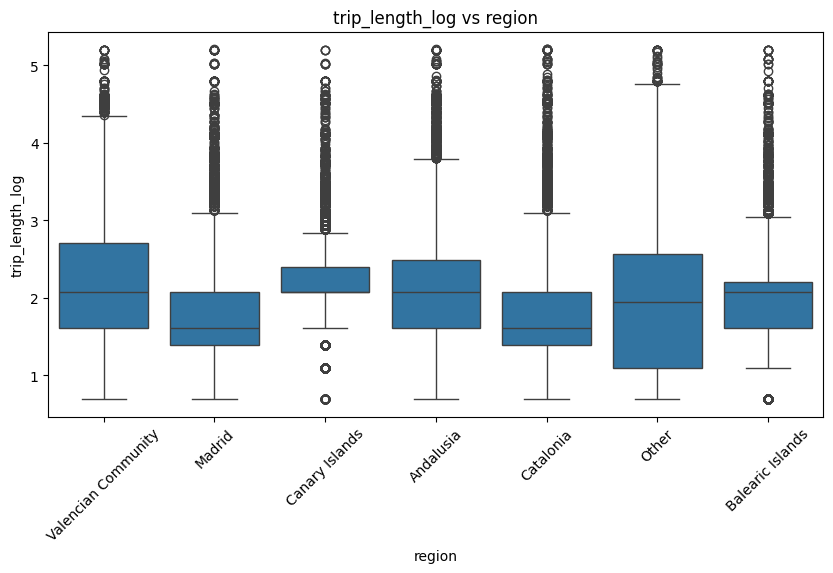

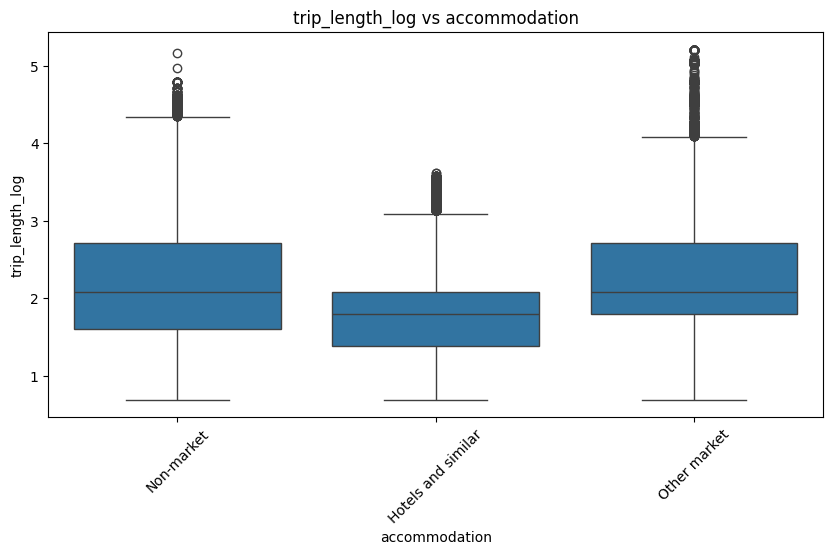

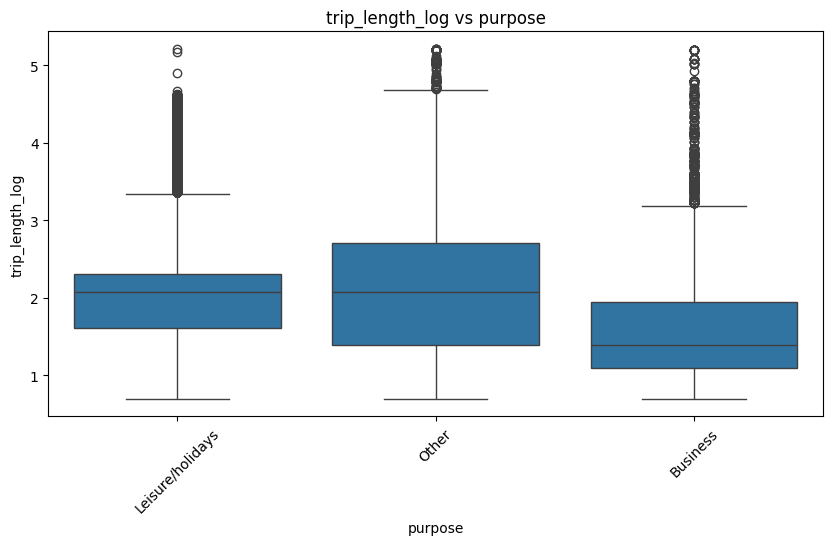

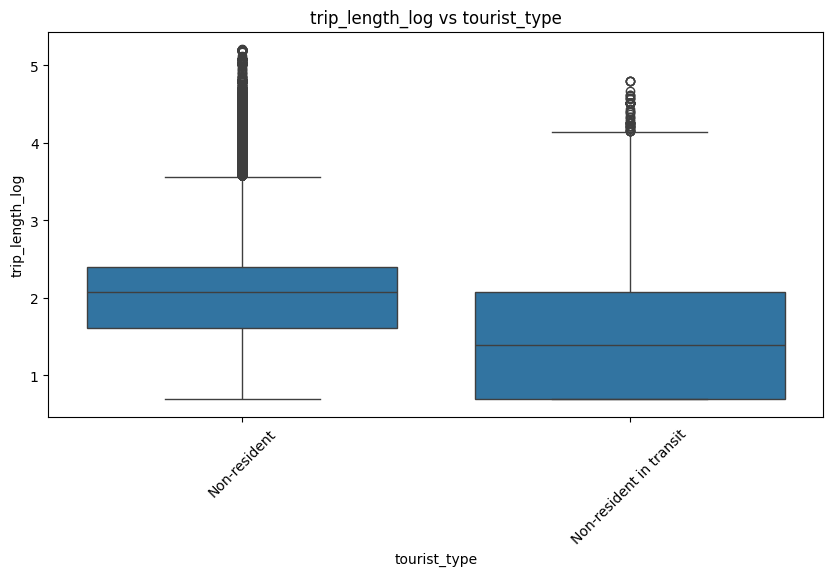

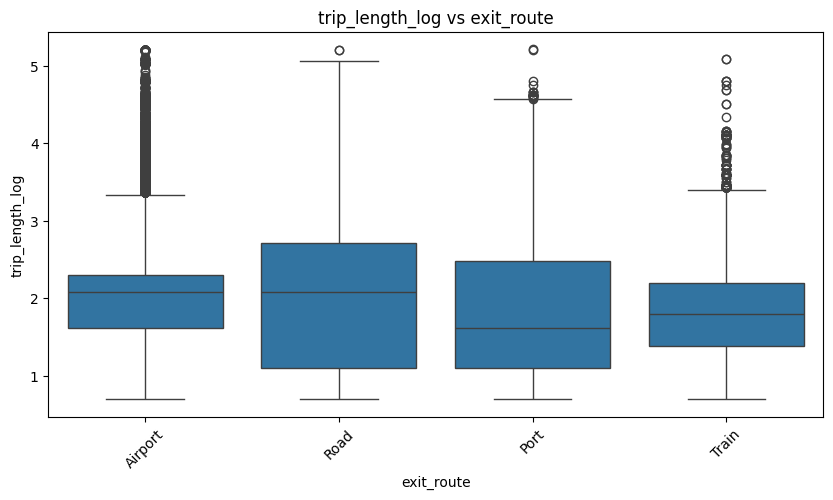

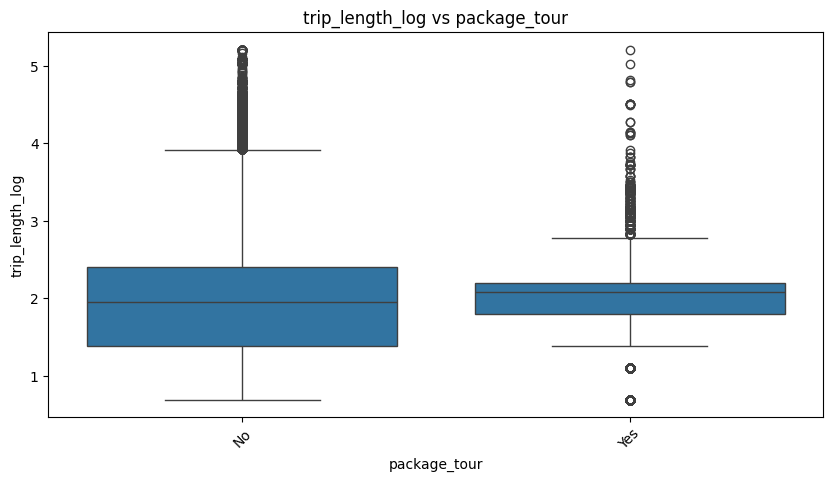

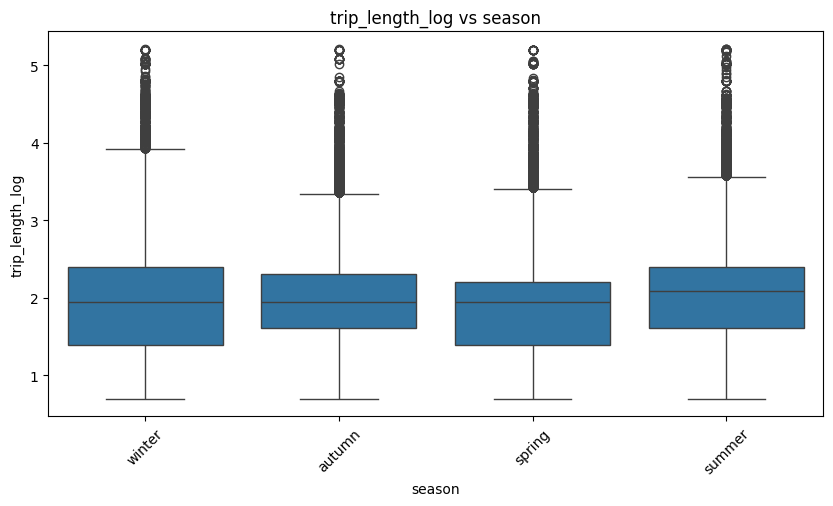

In [31]:
plot_boxplots(df, categorical_cols, target="trip_length_log")

Now that we have examined the distribution of the target variables by country and region, we can decide which categories to group. The average expenditure is higher for Russia and Rest of the World, while trip length is lower for the United Kingdom. The remaining categories do not show significant differences. Therefore, we will keep just three country categories.

In [32]:
df["country"].value_counts()

country
Switzerland          42643
France               31384
Germany              28921
Rest of the world    21406
Netherlands          17510
Rest of America      17256
United States        15451
Russia               13960
Portugal             13664
Belgium              11663
Nordic countries      7813
Italy                 7479
United Kingdom        6638
Name: count, dtype: int64

In [33]:
def group_country(x):
    if x == "United Kingdom":
        return "United Kingdom"
    elif x in ["Russia", "Rest of the world"]:
        return "Russia + Rest of the world"
    else:
        return "Occident and America"

df["country"] = df["country"].apply(group_country)

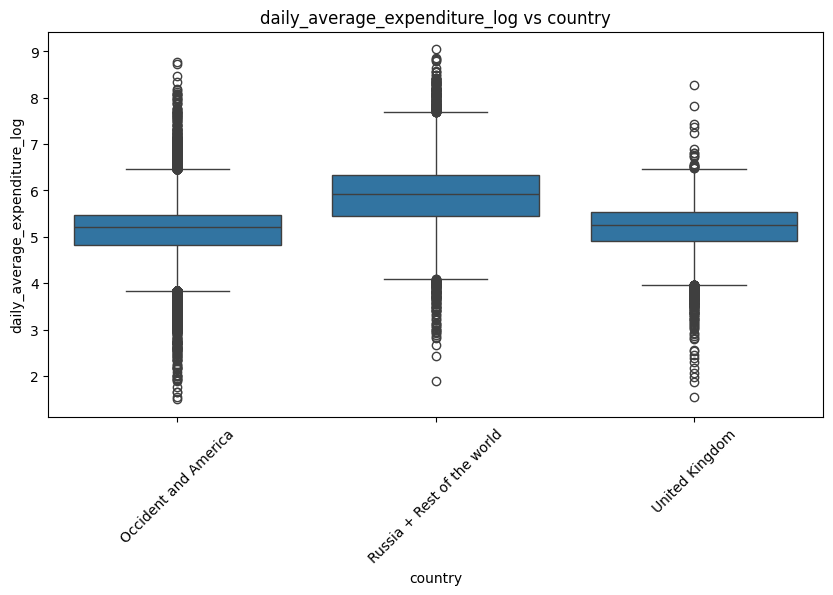

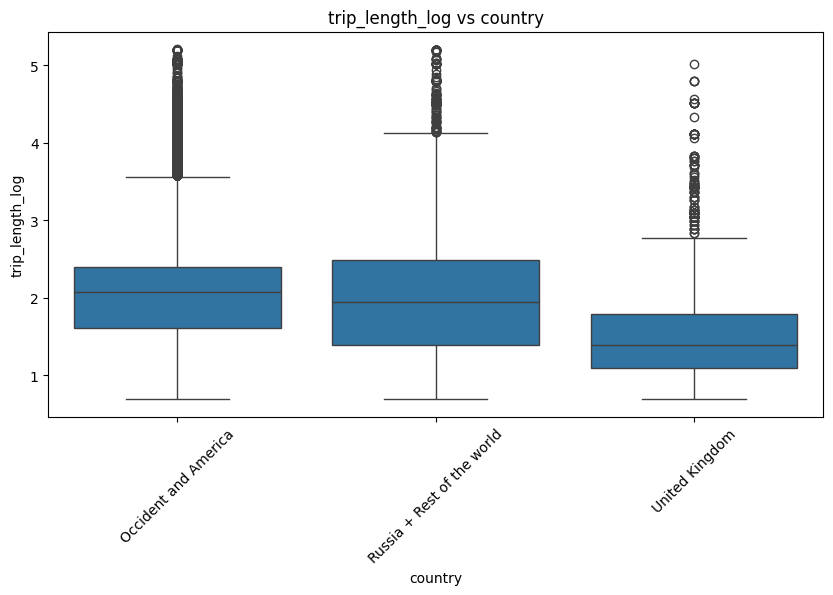

In [34]:
plot_boxplots(df, ["country"], target="daily_average_expenditure_log")
plot_boxplots(df, ["country"], target="trip_length_log")

Finally, we examine the relationship between the numerical columns.

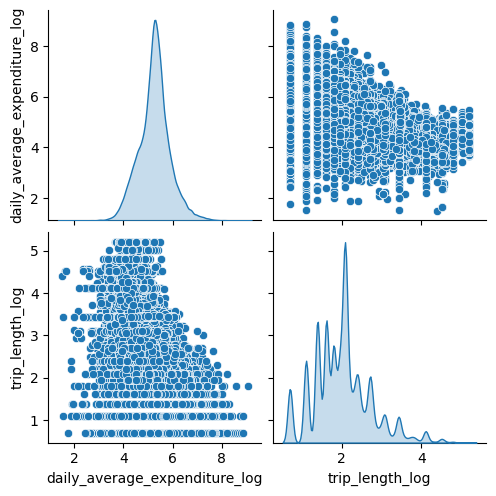

In [35]:
numerical_cols = ["daily_average_expenditure_log", "trip_length_log"]
plot_scatter_matrix(df, numerical_cols)

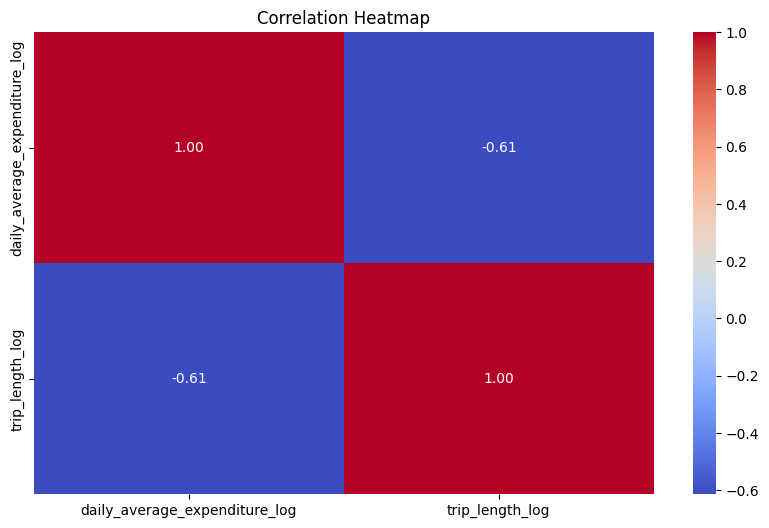

In [36]:
plot_correlation_heatmap(df, numerical_cols)

There appears to be a negative correlation between trip length and daily average expenditure: as the duration of the trip increases, the daily spending tends to decrease. This relationship is visible in the scatter plots, although there is considerable dispersion, which is expected—longer trips often lead to more budget-conscious daily spending.

## Temporal Analysis

Let's just take a look at the evolution of the two numerical variables over time.

In [37]:
df.head()

,tourist_type,exit_route,country,region,accommodation,purpose,package_tour,trip_length,date,season,daily_average_expenditure,daily_average_expenditure_log,trip_length_log
0,Non-resident,Airport,Occident and America,Valencian Community,Non-market,Leisure/holidays,No,14,2023-12-01,winter,129.318995,4.869985,2.708050
1,Non-resident,Airport,Occident and America,Valencian Community,Non-market,Leisure/holidays,No,16,2023-12-01,winter,127.224771,4.853785,2.833213
2,Non-resident,Airport,Occident and America,Madrid,Hotels and similar,Leisure/holidays,No,9,2023-12-01,winter,273.413983,5.614638,2.302585
3,Non-resident,Airport,Occident and America,Valencian Community,Non-market,Leisure/holidays,No,27,2023-12-01,winter,111.493501,4.722895,3.332205
4,Non-resident,Airport,Occident and America,Canary Islands,Non-market,Other,No,14,2023-12-01,winter,124.846663,4.835064,2.708050


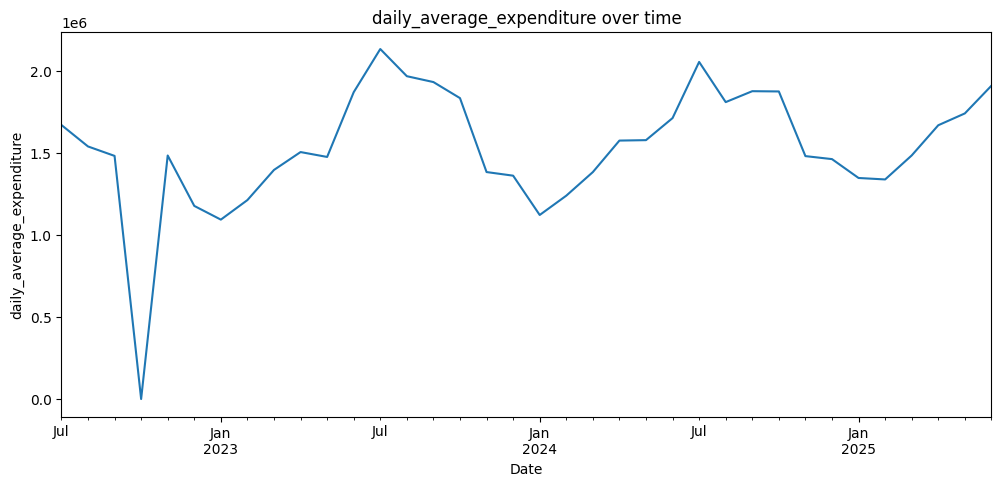

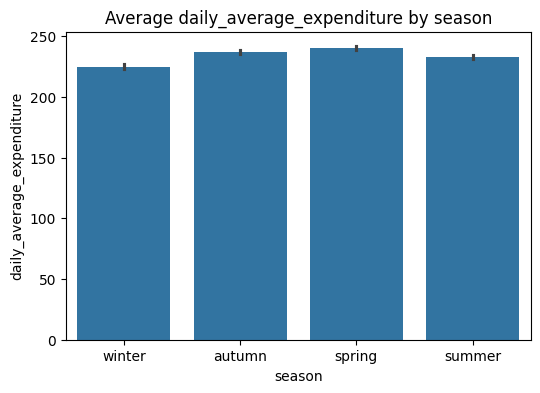

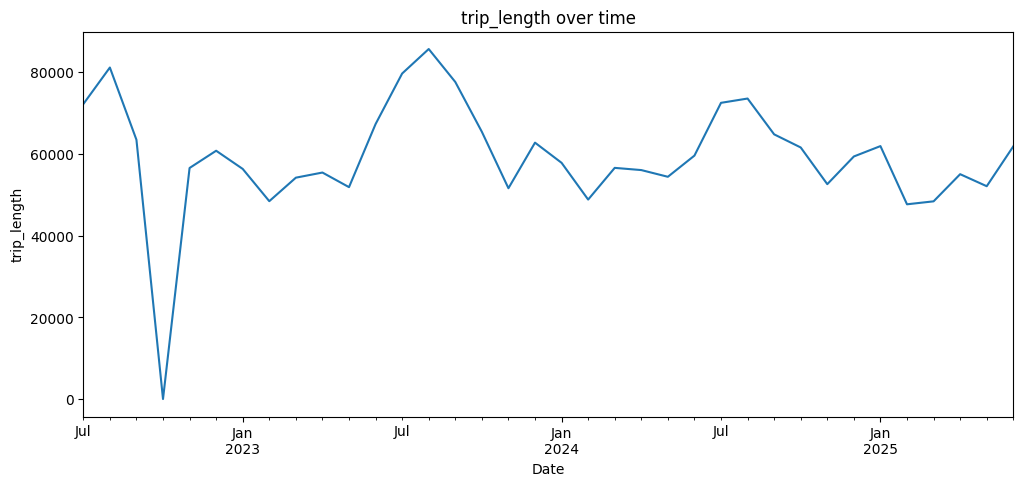

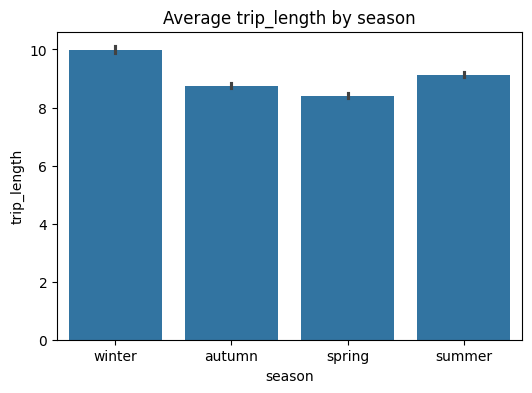

In [38]:
# Temporal analysis for daily_average_expenditure
plot_time_series(df, "date", "daily_average_expenditure", freq="ME")
plot_seasonality(df, "season", "daily_average_expenditure")

# Temporal analysis for trip_length
plot_time_series(df, "date", "trip_length", freq="ME")
plot_seasonality(df, "season", "trip_length")

Clearly it seems to be some seasonality, but the data is not good enough to be clear. Also, as we have already worked with seasonality and ARIMA with FRONTUR data, we don't want to treat it with this data.

## Clustering

### One-Hot Encoding + K-means

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Variables numéricas log
num_vars = ["daily_average_expenditure_log", "trip_length_log"]

# Variables categóricas a incluir
cat_vars = ["accommodation", "purpose", "season", "country", "region"]

# One-hot encoding
df_encoded = pd.get_dummies(df[cat_vars], drop_first=True)

# Concatenar numéricas y categóricas
X = pd.concat([df[num_vars], df_encoded], axis=1)

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)


In [40]:
df["cluster"].value_counts()

cluster
1    103359
3     65753
2     34545
0     32131
Name: count, dtype: int64

### PCA

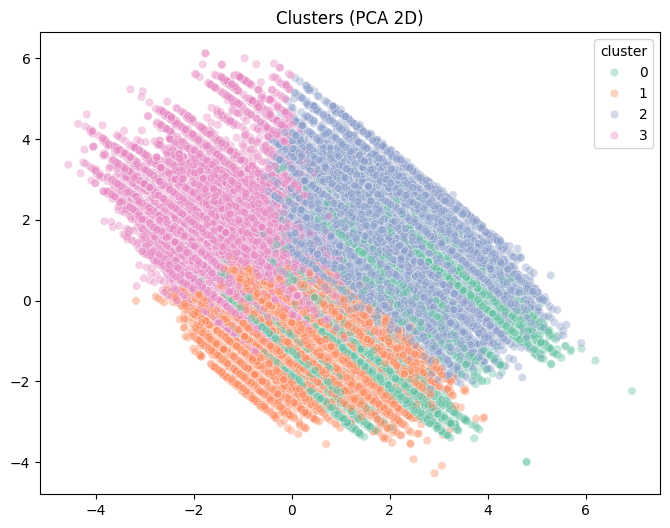

In [41]:
# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["cluster"], palette="Set2", alpha=0.4)
plt.title("Clusters (PCA 2D)")
plt.show()

Next cell can be heavy to load, it is commented by default.

In [42]:
"""
# PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# DataFrame for plotly
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])
df_pca["cluster"] = df["cluster"]

# Interactive scatter 3D
fig = px.scatter_3d(
    df_pca,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    opacity=0.5,
    color_discrete_sequence=px.colors.qualitative.Set2,
    title="Clusters (PCA 3D)"
)

fig.show()
"""

'\n# PCA with 3 components\npca = PCA(n_components=3)\nX_pca = pca.fit_transform(X_scaled)\n\n# DataFrame for plotly\ndf_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3"])\ndf_pca["cluster"] = df["cluster"]\n\n# Interactive scatter 3D\nfig = px.scatter_3d(\n    df_pca,\n    x="PC1", y="PC2", z="PC3",\n    color="cluster",\n    opacity=0.5,\n    color_discrete_sequence=px.colors.qualitative.Set2,\n    title="Clusters (PCA 3D)"\n)\n\nfig.show()\n'

# Final Report